In [1]:
"""Dynamic and task-related higher-order interactions."""
import numpy as np
import xarray as xr
import pandas as pd
from numpy import genfromtxt

import itertools

from frites.conn import conn_io
from frites.io import logger, check_attrs
from frites.utils import parallel_func
from frites.core import copnorm_nd



def ent_g(x):
    """Entropy of a tensor of shape (..., n_vars, n_trials)"""
    nvarx, ntrl = x.shape[-2], x.shape[-1]

    # covariance
    c = np.einsum('...ij, ...kj->...ik', x, x)
    c /= float(ntrl - 1.)
    chc = np.linalg.cholesky(c)

    # entropy in nats
    hx = np.log(np.einsum('...ii->...i', chc)).sum(-1) + 0.5 * nvarx * (
        np.log(2 * np.pi) + 1.0)
    return hx


def compute_oinfo(x, ind):
    """Compute the O-info.

    x.shape = (..., n_vars, n_trials)
    ind = indices for tensor-computations
    """
    nvars = x.shape[-2]
    o = (nvars - 2) * ent_g(x)
    o += (ent_g(x[..., np.newaxis, :]) - ent_g(x[..., ind, :])).sum(1)
    return o


def combinations(n, k, roi, task_related=False):
    """Get combinations."""
    combs = np.array(list(itertools.combinations(np.arange(n), k)))

    # add behavior as a final columns
    if task_related:
        combs = np.c_[combs, np.full((combs.shape[0],), n)]

    # build brain region names
    roi_st = ['-'.join(r) for r in roi[combs].tolist()]

    return combs, roi_st


def conn_hoi(data, y=None, times=None, roi=None, minsize=3, maxsize=5,
             verbose=None):
    """Dynamic, possibly task-related, higher-order interactions.

    Parameters
    ----------
    data : array_like
        Electrophysiological data. Several input types are supported :

            * Standard NumPy arrays of shape (n_epochs, n_roi, n_times)
            * mne.Epochs
            * xarray.DataArray of shape (n_epochs, n_roi, n_times)

    y : array_like
        The feature of shape (n_trials,) for estimating task-related O-info.
    roi : array_like | None
        Array of region of interest name of shape (n_roi,)
    times : array_like | None
        Array of time points of shape (n_times,)
    minsize, maxsize : int | 3, 5
        Minimum and maximum size of the multiplets

    Returns
    -------
    oinfo : array_like
        The O-info array of shape (n_multiplets, n_times) where positive values
        reflect redundant dominated interactions and negative values stand for
        synergistic dominated interactions.
    """
    
    # ________________________________ INPUTS _________________________________
    # inputs conversion
    is_task_related = isinstance(y, (str, list, np.ndarray, tuple))
    kw_links = {'directed': False, 'net': False}
    data, cfg = conn_io(
        data, y=y, times=times, roi=roi, name='DynOinfo', verbose=verbose,
        kw_links=kw_links
    )

    # extract variables
    x, attrs = data.data, cfg['attrs']
    y, roi, times = data['y'].data, data['roi'].data, data['times'].data
    n_roi = len(roi)

    # get the maximum size of the multiplets investigated
    if not isinstance(maxsize, int):
        maxsize = n_roi
    maxsize = max(1, maxsize)
    assert maxsize > minsize

    logger.info(f"Compute the {'task-related ' * is_task_related} HOI "
                f"(min={minsize}; max={maxsize})")

    # ________________________________ O-INFO _________________________________
    logger.info("    Copnorm the data")

    # for task-related, add behavior along spatial dimension
    if is_task_related:
        y = np.tile(y.reshape(-1, 1, 1), (1, 1, len(times)))
        x = np.concatenate((x, y), axis=1)
        roi = np.r_[roi, ['beh']]

    # copnorm and demean the data
    x = copnorm_nd(x.copy(), axis=0)
    x = (x - x.mean(axis=0, keepdims=True))

    # make the data (n_times, n_roi, n_trials)
    x = x.transpose(2, 1, 0)

    oinfo, roi_o = [], []
    for msize in range(minsize, maxsize + 1):
        # ------------------------------ INDICES ------------------------------
        ish = msize if not is_task_related else msize + 1
        ind = np.zeros((ish, ish), dtype=int)
        vec = np.arange(ish)
        for shift in range(ish):
            ind[shift, :] = np.roll(vec, -shift)
        ind = ind[:, 1:]

        # ----------------------------- MULTIPLETS ----------------------------
        logger.info(f"    Multiplets of size {msize}")
        combs, _roi_o = combinations(
            n_roi, msize, roi, task_related=is_task_related)
        roi_o += _roi_o

        # ------------------------------- O-INFO ------------------------------
        for mult in combs:
            _oinfo = compute_oinfo(x[:, mult, :], ind)
            oinfo += [_oinfo]
    oinfo = np.stack(oinfo, 0)

    # _______________________________ OUTPUTS _________________________________
    attrs.update(dict(
        task_related=is_task_related, minsize=minsize, maxsize=maxsize
    ))
    oinfo = xr.DataArray(
        oinfo, dims=('roi', 'times'), coords=(roi_o, times), name="Oinfo",
        attrs=check_attrs(attrs)
    )

    return oinfo

"""Dynamic and task-related higher-order interactions."""
from math import comb

import numpy as np
import scipy as sp
import xarray as xr

import itertools
from mne.utils import ProgressBar

from frites.conn import conn_io
from frites.io import logger, check_attrs
from frites.core import mi_nd_gg, mi_model_nd_gd, copnorm_nd 
from frites.utils import parallel_func
from frites.core import copnorm_nd

from frites.config import CONFIG


def ent_g(x, biascorrect=True):
    """Entropy of a tensor of shape (..., n_vars, n_trials)"""
    nvarx, ntrl = x.shape[-2], x.shape[-1]

    # covariance
    c = np.einsum('...ij, ...kj->...ik', x, x)
    c /= float(ntrl - 1.)
    chc = np.linalg.cholesky(c)

    # entropy in nats
    hx = np.log(np.einsum('...ii->...i', chc)).sum(-1) + 0.5 * nvarx * (
        np.log(2 * np.pi) + 1.0)

    ln2 = np.log(2)
    if biascorrect:
        psiterms = sp.special.psi((ntrl - np.arange(1, nvarx + 1).astype(
            float)) / 2.) / 2.
        dterm = (ln2 - np.log(ntrl - 1.)) / 2.
        hx = hx - nvarx * dterm - psiterms.sum()

    return hx

def _mi_estimation(x, y, mi_type, mvaxis=None):
    """Compute the MI on each roi.
    x.shape = (n_times, {1, Nd}, n_trials)
    y.shape = ({1, Nd}, n_trials)
    """
    x = np.ascontiguousarray(x)
    cfg_mi = CONFIG["KW_GCMI"]
    if mi_type == 'cc':
        y = np.atleast_2d(y)[np.newaxis, ...]
        # repeat y to match x shape
        y = np.tile(y, (x.shape[0], 1, 1))
        return mi_nd_gg(x, y, **cfg_mi)
    elif mi_type == 'cd':
        return mi_model_nd_gd(x, y, **cfg_mi)

def compute_syn(x, y, mi_type):
    """Compute the synergy among HOIs.
    """
    
    # size
    n_roi = x.shape[1]

    # total information for multiple
    mi_tot = _mi_estimation(x, y, mi_type, mvaxis=-2)
    
    # total information for -j 
    mi_tot_j = np.zeros(x.shape[0:2])
    for i in range(n_roi):
        ind_j = np.setdiff1d(range(n_roi), i)
        x_j = x[:, ind_j, :]
        mi_tot_j[:, i] = _mi_estimation(x_j, y, mi_type, mvaxis=-2)
    max_mi_tot_j = np.max(mi_tot_j, axis=-1)

    # Synergy
    syn = mi_tot - max_mi_tot_j

    return syn

def compute_oinfo(x, ind):
    """Compute the O-info.
    x.shape = (..., n_vars, n_trials)
    ind = indices for tensor-computations
    """
    nvars = x.shape[-2]
    o = (nvars - 2) * ent_g(x)
    o += (ent_g(x[..., np.newaxis, :]) - ent_g(x[..., ind, :])).sum(1)
    return o


def combinations(n, k, roi, task_related=False):
    """Get combinations."""
    combs = np.array(list(itertools.combinations(np.arange(n), k)))

    # add behavior as a final columns
    if task_related:
        combs = np.c_[combs, np.full((combs.shape[0],), n)]

    # build brain region names
    roi_st = ['-'.join(r) for r in roi[combs].tolist()]

    return combs, roi_st


def conn_hoi_oinfo(data, y=None, times=None, roi=None, minsize=3, maxsize=5,
             verbose=None):
    """Dynamic, possibly task-related, higher-order interactions.
    Parameters
    ----------
    data : array_like
        Electrophysiological data. Several input types are supported :
            * Standard NumPy arrays of shape (n_epochs, n_roi, n_times)
            * mne.Epochs
            * xarray.DataArray of shape (n_epochs, n_roi, n_times)
    y : array_like
        The feature of shape (n_trials,) for estimating task-related O-info.
    roi : array_like | None
        Array of region of interest name of shape (n_roi,)
    times : array_like | None
        Array of time points of shape (n_times,)
    minsize, maxsize : int | 3, 5
        Minimum and maximum size of the multiplets
    Returns
    -------
    oinfo : array_like
        The O-info array of shape (n_multiplets, n_times) where positive values
        reflect redundant dominated interactions and negative values stand for
        synergistic dominated interactions.
    """
    # ________________________________ INPUTS _________________________________
    # inputs conversion
    is_task_related = isinstance(y, (str, list, np.ndarray, tuple))
    kw_links = {'directed': False, 'net': False}
    data, cfg = conn_io(
        data, y=y, times=times, roi=roi, name='DynOinfo', verbose=verbose,
        kw_links=kw_links
    )

    # extract variables
    x, attrs = data.data, cfg['attrs']
    y, roi, times = data['y'].data, data['roi'].data, data['times'].data
    n_roi, n_times = len(roi), len(times)

    # get the maximum size of the multiplets investigated
    if not isinstance(maxsize, int):
        maxsize = n_roi
    maxsize = max(1, maxsize)
    assert maxsize > minsize

    # get the number of multiplets
    n_mults = 0
    for msize in range(minsize, maxsize + 1):
        n_mults += comb(n_roi, msize)
    pbar = ProgressBar(range(n_mults))

    logger.info(f"Compute the {'task-related ' * is_task_related} HOI "
                f"(min={minsize}; max={maxsize})")

    # ________________________________ O-INFO _________________________________
    logger.info("    Copnorm the data")

    # for task-related, add behavior along spatial dimension
    if is_task_related:
        y = np.tile(y.reshape(-1, 1, 1), (1, 1, len(times)))
        x = np.concatenate((x, y), axis=1)
        roi = np.r_[roi, ['beh']]

    # copnorm and demean the data
    x = copnorm_nd(x.copy(), axis=0)
    x = (x - x.mean(axis=0, keepdims=True))

    # make the data (n_times, n_roi, n_trials)
    x = x.transpose(2, 1, 0)

    oinfo, roi_o = [], []
    for msize in range(minsize, maxsize + 1):
        # ------------------------------ INDICES ------------------------------
        ish = msize if not is_task_related else msize + 1
        ind = np.zeros((ish, ish), dtype=int)
        vec = np.arange(ish)
        for shift in range(ish):
            ind[shift, :] = np.roll(vec, -shift)
        ind = ind[:, 1:]

        # ----------------------------- MULTIPLETS ----------------------------
        logger.info(f"    Multiplets of size {msize}")
        combs, _roi_o = combinations(
            n_roi, msize, roi, task_related=is_task_related)
        roi_o += _roi_o

        # ------------------------------- O-INFO ------------------------------
        _oinfo = np.zeros((comb(n_roi, msize), n_times))
        for n_m, mult in enumerate(combs):
            _oinfo[n_m, :] = compute_oinfo(x[:, mult, :], ind)
            pbar.update_with_increment_value(1)

        oinfo.append(_oinfo)
    oinfo = np.concatenate(oinfo, axis=0)

    # _______________________________ OUTPUTS _________________________________
    attrs.update(dict(
        task_related=is_task_related, minsize=minsize, maxsize=maxsize
    ))
    oinfo = xr.DataArray(
        oinfo, dims=('roi', 'times'), coords=(roi_o, times), name="Oinfo",
        attrs=check_attrs(attrs)
    )

    return oinfo

def conn_hoi_red(data, y=None, times=None, roi=None, mi_type='cc', gcrn=True,
                 minsize=3, maxsize=5, verbose=None):
    """Redundancy among higher-order interactions.
    Parameters
    ----------
    data : array_like
        Electrophysiological data. Several input types are supported :
            * Standard NumPy arrays of shape (n_epochs, n_roi, n_times)
            * mne.Epochs
            * xarray.DataArray of shape (n_epochs, n_roi, n_times)
    y : array_like
        The feature of shape (n_trials,) for estimating task-related O-info.
    roi : array_like | None
        Array of region of interest name of shape (n_roi,)
    mi_type : {'cc', 'cd'}
        Mutual information type. Switch between :
            * 'cc' : if the y input is a continuous regressor
            * 'cd' : if the y input is a discret vector with categorical
              integers inside
    gcrn : bool | True
        Specify if the Gaussian Copula Rank Normalization should be applied.
        Default is True.
    times : array_like | None
        Array of time points of shape (n_times,)
    minsize, maxsize : int | 3, 5
        Minimum and maximum size of the multiplets
    Returns
    -------
    oinfo : array_like
        The O-info array of shape (n_multiplets, n_times) where positive values
        reflect redundant dominated interactions and negative values stand for
        synergistic dominated interactions.
    """
    # ________________________________ INPUTS _________________________________
    # inputs conversion
    kw_links = {'directed': False, 'net': False}
    data, cfg = conn_io(
        data, y=y, times=times, roi=roi, name='Red', verbose=verbose,
        kw_links=kw_links
    )

    # extract variables
    x, attrs = data.data, cfg['attrs']
    y, roi, times = data['y'].data, data['roi'].data, data['times'].data
    n_roi, n_times = len(roi), len(times)

    # get the maximum size of the multiplets investigated
    if not isinstance(maxsize, int):
        maxsize = n_roi
    maxsize = max(1, maxsize)
    assert maxsize > minsize

    # get the number of multiplets
    n_mults = 0
    for msize in range(minsize, maxsize + 1):
        n_mults += comb(n_roi, msize)

    logger.info(f"Compute HOI redundancy"
                f"(min={minsize}; max={maxsize})")

    # ________________________________ Red _________________________________
    logger.info("    Copnorm the data")
    
    # gcrn
    if gcrn:
        logger.info("    Apply the Gaussian Copula Rank Normalization")
        x = copnorm_nd(x, axis=0)
        if mi_type == 'cc':
            y = copnorm_nd(y, axis=0)

    # make the data (n_times, n_roi, n_trials)
    x = x.transpose(1, 2, 0)

    # compute mi on each node of the network
    mi_node = np.zeros((n_roi, n_times), dtype=float)
    for n_r in range(n_roi):
        mi_node[n_r, :] = _mi_estimation(x[n_r, :, np.newaxis, :], y, mi_type)

    # Loop over multiples
    red, roi_o = [], []
    for msize in range(minsize, maxsize + 1):

        # ------------------------------ INDICES ------------------------------
        ish = msize + 1
        ind = np.zeros((ish, ish), dtype=int)
        vec = np.arange(ish)
        for shift in range(ish):
            ind[shift, :] = np.roll(vec, -shift)
        ind = ind[:, 1:]

        # ----------------------------- MULTIPLETS ----------------------------
        logger.info(f"    Multiplets of size {msize}")
        combs, _roi_o = combinations(n_roi, msize, roi)
        roi_o += _roi_o

        # --------------------------- RED using MMI ---------------------------
        _red = np.zeros((comb(n_roi, msize), n_times))
        for n_m, mult in enumerate(combs):
            _red[n_m, :] = np.min(mi_node[mult, :], axis=0)
        red.append(_red)

    red = np.concatenate(red, axis=0)

    # _______________________________ OUTPUTS _________________________________
    attrs.update(dict(minsize=minsize, maxsize=maxsize))
    red = xr.DataArray(
        red, dims=('roi', 'times'), coords=(roi_o, times), name="Red",
        attrs=check_attrs(attrs)
    )

    return red

def conn_hoi_syn(data, y=None, times=None, roi=None, mi_type='cc', gcrn=True,
                 minsize=3, maxsize=5, verbose=None):
    """Synergy among higher-order interactions.
    Parameters
    ----------
    data : array_like
        Electrophysiological data. Several input types are supported :
            * Standard NumPy arrays of shape (n_epochs, n_roi, n_times)
            * mne.Epochs
            * xarray.DataArray of shape (n_epochs, n_roi, n_times)
    y : array_like
        The feature of shape (n_trials,) for estimating task-related O-info.
    roi : array_like | None
        Array of region of interest name of shape (n_roi,)
    mi_type : {'cc', 'cd'}
        Mutual information type. Switch between :
            * 'cc' : if the y input is a continuous regressor
            * 'cd' : if the y input is a discret vector with categorical
              integers inside
    gcrn : bool | True
        Specify if the Gaussian Copula Rank Normalization should be applied.
        Default is True.
    times : array_like | None
        Array of time points of shape (n_times,)
    minsize, maxsize : int | 3, 5
        Minimum and maximum size of the multiplets
    Returns
    -------
    oinfo : array_like
        The O-info array of shape (n_multiplets, n_times) where positive values
        reflect redundant dominated interactions and negative values stand for
        synergistic dominated interactions.
    """
    # ________________________________ INPUTS _________________________________
    # inputs conversion
    kw_links = {'directed': False, 'net': False}
    data, cfg = conn_io(
        data, y=y, times=times, roi=roi, name='Red', verbose=verbose,
        kw_links=kw_links
    )

    # extract variables
    x, attrs = data.data, cfg['attrs']
    y, roi, times = data['y'].data, data['roi'].data, data['times'].data
    n_roi = len(roi)

    # get the maximum size of the multiplets investigated
    if not isinstance(maxsize, int):
        maxsize = n_roi
    maxsize = max(1, maxsize)
    assert maxsize > minsize

    # get the number of multiplets
    n_mults = 0
    for msize in range(minsize, maxsize + 1):
        n_mults += comb(n_roi, msize)

    logger.info(f"Compute HOI redundancy"
                f"(min={minsize}; max={maxsize})")

    # ________________________________ Syn _________________________________
    logger.info("    Copnorm the data")
    
    # gcrn
    if gcrn:
        logger.info("    Apply the Gaussian Copula Rank Normalization")
        x = copnorm_nd(x, axis=0)
        if mi_type == 'cc':
            y = copnorm_nd(y, axis=0)

    # make the data (n_times, n_roi, n_trials)
    x = x.transpose(2, 1, 0)

    # Loop over multiples
    syn, roi_o = [], []
    for msize in range(minsize, maxsize + 1):

        # ------------------------------ INDICES ------------------------------
        ish = msize + 1
        ind = np.zeros((ish, ish), dtype=int)
        vec = np.arange(ish)
        for shift in range(ish):
            ind[shift, :] = np.roll(vec, -shift)
        ind = ind[:, 1:]

        # ----------------------------- MULTIPLETS ----------------------------
        logger.info(f"    Multiplets of size {msize}")
        combs, _roi_o = combinations(n_roi, msize, roi)
        roi_o += _roi_o

        # --------------------------- SYN using MMI ---------------------------
        _syn = np.zeros((comb(n_roi, msize), n_times))
        for n_m, mult in enumerate(combs):
            _syn[n_m, :] = compute_syn(x[:, mult, :], y, mi_type)
        syn.append(_syn)

    syn = np.concatenate(syn, axis=0)

    # _______________________________ OUTPUTS _________________________________
    attrs.update(dict(minsize=minsize, maxsize=maxsize))
    syn = xr.DataArray(
        syn, dims=('roi', 'times'), coords=(roi_o, times), name="Syn",
        attrs=check_attrs(attrs)
    )

    return syn


In [ ]:


"""Dynamic and task-related higher-order interactions."""
from math import comb

from functools import partial

import jax
import jax.numpy as jnp
import jax.scipy.special as jsp

import numpy as np
import xarray as xr

import itertools

from frites.conn import conn_io
from frites.io import logger, check_attrs
from frites.core import copnorm_nd


@partial(jax.jit, static_argnums=1)
def ent_g(x: jnp.array, biascorrect=True) -> jnp.array:
    """Entropy of a tensor of shape (..., n_vars, n_trials)"""
    nvarx, ntrl = x.shape[-2], x.shape[-1]

    # covariance
    c = jnp.einsum('...ij, ...kj->...ik', x, x)
    c /= float(ntrl - 1.)
    chc = jnp.linalg.cholesky(c)

    # entropy in nats
    hx = jnp.log(jnp.einsum('...ii->...i', chc)).sum(-1) + 0.5 * nvarx * (
        jnp.log(2 * jnp.pi) + 1.0)

    ln2 = jnp.log(2)
    if biascorrect:
        psiterms = jsp.digamma((ntrl - jnp.arange(1, nvarx + 1).astype(
            float)) / 2.) / 2.
        dterm = (ln2 - jnp.log(ntrl - 1.)) / 2.
        hx = hx - nvarx * dterm - psiterms.sum()

    return hx


@partial(jax.jit)
def oinfo_smult(x: jnp.array, ind: jnp.array) -> jnp.array:
    """Compute the O-info of a single multiplet.
    x.shape = (..., n_vars, n_trials)
    ind = indices for tensor-computations
    """
    nvars = x.shape[-2]
    o = (nvars - 2) * ent_g(x) + (ent_g(x[..., jnp.newaxis, :]) - ent_g(
        x[..., ind, :])).sum(1)
    return o


@partial(jax.jit)
def oinfo_mmult(x: jnp.array, comb: jnp.array) -> (jnp.array, jnp.array):
    """Compute the O-info on several multiplets.
    """
    # build indices
    msize = len(comb)
    ind = jnp.mgrid[0:msize, 0:msize].sum(0) % msize

    return x, oinfo_smult(x[:, comb, :], ind[:, 1:])


def combinations(n, k, roi, task_related=False, sort=True):
    """Get combinations."""
    combs = np.array(list(itertools.combinations(np.arange(n), k)))

    # add behavior as a final columns
    if task_related:
        combs = np.c_[combs, np.full((combs.shape[0],), n)]

    # build brain region names
    if not sort:
        roi_st = ['-'.join(r) for r in roi[combs].tolist()]
    else:
        roi_st = ['-'.join(r) for r in np.sort(roi[combs]).tolist()]

    return jnp.asarray(combs), roi_st


def conn_hoi(data, y=None, times=None, roi=None, minsize=3, maxsize=5,
             sort=True, verbose=None):
    """Dynamic, possibly task-related, higher-order interactions.
    Parameters
    ----------
    data : array_like
        Electrophysiological data. Several input types are supported :
            * Standard NumPy arrays of shape (n_epochs, n_roi, n_times)
            * mne.Epochs
            * xarray.DataArray of shape (n_epochs, n_roi, n_times)
    y : array_like
        The feature of shape (n_trials,) for estimating task-related O-info.
    roi : array_like | None
        Array of region of interest name of shape (n_roi,)
    times : array_like | None
        Array of time points of shape (n_times,)
    minsize, maxsize : int | 3, 5
        Minimum and maximum size of the multiplets
    Returns
    -------
    oinfo : array_like
        The O-info array of shape (n_multiplets, n_times) where positive values
        reflect redundant dominated interactions and negative values stand for
        synergistic dominated interactions.
    """
    # ________________________________ INPUTS _________________________________
    # inputs conversion
    is_task_related = isinstance(y, (str, list, np.ndarray, tuple))
    kw_links = {'directed': False, 'net': False}
    data, cfg = conn_io(
        data, y=y, times=times, roi=roi, name='DynOinfo', verbose=verbose,
        kw_links=kw_links
    )

    # extract variables
    x, attrs = data.data, cfg['attrs']
    y, roi, times = data['y'].data, data['roi'].data, data['times'].data
    n_roi = len(roi)

    # get the maximum size of the multiplets investigated
    if not isinstance(maxsize, int):
        maxsize = n_roi
    maxsize = max(1, maxsize)
    assert maxsize > minsize

    # get the number of multiplets
    n_mults = 0
    for msize in range(minsize, maxsize + 1):
        n_mults += comb(n_roi, msize)

    logger.info(f"Compute the {'task-related ' * is_task_related} HOI "
                f"(min={minsize}; max={maxsize})")

    # ________________________________ O-INFO _________________________________
    logger.info("    Copnorm the data")

    # for task-related, add behavior along spatial dimension
    if is_task_related:
        y = np.tile(y.reshape(-1, 1, 1), (1, 1, len(times)))
        x = np.concatenate((x, y), axis=1)
        roi = np.r_[roi, ['beh']]

    # copnorm and demean the data
    x = copnorm_nd(x.copy(), axis=0)
    x = (x - x.mean(axis=0, keepdims=True))

    # make the data (n_times, n_roi, n_trials)
    x = jnp.asarray(x.transpose(2, 1, 0))

    oinfo, roi_o = [], []
    for msize in range(minsize, maxsize + 1):
        # ----------------------------- MULTIPLETS ----------------------------
        logger.info(f"    Multiplets of size {msize}")
        combs, _roi_o = combinations(
            n_roi, msize, roi, task_related=is_task_related, sort=sort
        )
        roi_o += _roi_o

        # ------------------------------- O-INFO ------------------------------
        _, _oinfo = jax.lax.scan(oinfo_mmult, x, combs)

        oinfo.append(np.asarray(_oinfo))
    oinfo = np.concatenate(oinfo, axis=0)

    # _______________________________ OUTPUTS _________________________________
    attrs.update(dict(
        task_related=is_task_related, minsize=minsize, maxsize=maxsize
    ))
    oinfo = xr.DataArray(
        oinfo, dims=('roi', 'times'), coords=(roi_o, times), name="Oinfo",
        attrs=check_attrs(attrs)
    )

    return oinfo

In [2]:
from pathlib import Path
import sys
import numpy as np
import matplotlib.pyplot as plt

import pickle
import networkx as nx
import scipy.io as sio

import networkx as nx

from networkx import NetworkXException
import matplotlib.pyplot as plt

import itertools
from collections import defaultdict

import os, json
import pandas as pd

import hypernetx as hnx

import matplotlib.pyplot as plt
from frites import set_mpl_style

#import hyperplot

## Generating synthetic data set

simple case, no correlation between modules!

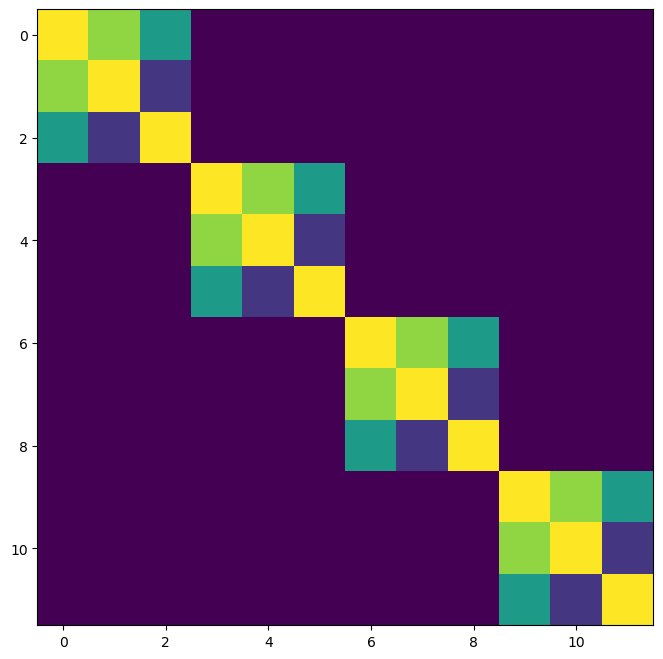

In [23]:
lambx=np.sqrt(0.99)
lamby=np.sqrt(0.7)
lambz=np.sqrt(0.3) 

n=12
n_triplets=4

n_trials=1000
times=30

node_color={0:'b',1:'b',2:'b',3:'b',4:'b',5:'b',6:'r',7:'r',8:'r',9:'r',10:'r',11:'r'}
covyz=[-0.3,-0.3,-0.3,-0.3] 

lamb=np.array([lambx, lamby, lambz])[np.newaxis]
    
oin=[]

cov=np.zeros((n,n))
for i in range(n_triplets):
    
    cov_yz=covyz[i]
    
    theta=np.array([[1-lambx**2,0,0],[0,1-lamby**2, cov_yz],[0,cov_yz,1-lambz**2]])
    
    k=3*i
    cov[k:k+3,k:k+3]=lamb*lamb.T + theta

# cov[5,2]=cov[2,5]=0.15
# cov[5,8]=cov[5,8]=0.15
# cov[5,11]=cov[11,5]=0.15
# cov[8,11]=cov[11,8]=0.15
# cov[2,11]=cov[11,2]=0.15
# cov[5,8]=cov[8,5]=0.15
# cov[8,2]=cov[2,8]=0.15


plt.imshow(cov)

mean=np.zeros(n)
x=np.random.multivariate_normal(mean, cov, size=n_trials, check_valid='warn', tol=1e-8)

In [24]:
x.shape

(1000, 12)

In [206]:
x=sv.loading('redundancy_gaussian_data')

In [207]:
simulated_data.shape

(1000, 13, 1)

In [25]:
#x=simulated_data[:,:,0]
n_sample=1000
path="C:/Users/matte/Documents/HOI/Manip_Quest/Analyses/"


n_sub, n_quest = x.shape

regions_label=[f"R{r+1}" for r in range(n_quest)]

arr=np.zeros((n_sub, n_quest, n_sample))

arr[:,:,0]=x

print(arr.shape)
for i in range(n_sample):

    arr[:,:,i]=x[np.random.choice(np.arange(n_sub), n_sub),:]


x = xr.DataArray(data=arr, dims=["Suj", "Quest","Time"],
                 coords=(np.arange(n_sub), regions_label, np.arange(n_sample)))



oinfo = conn_hoi_oinfo(x, minsize=3, maxsize=5, y=None, roi="Quest",
                 times="Time")


df = oinfo.to_pandas()


Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi names


(1000, 12, 1000)


  0%|          |  : 0/1507 [00:00<?,       ?it/s]

Compute the  HOI (min=3; max=5)
    Copnorm the data
    Multiplets of size 3
    Multiplets of size 4
    Multiplets of size 5


# Order 3

In [26]:
oinfo['roi'].data

array(['R1-R2-R3', 'R1-R2-R4', 'R1-R2-R5', ..., 'R7-R8-R10-R11-R12',
       'R7-R9-R10-R11-R12', 'R8-R9-R10-R11-R12'], dtype='<U17')

In [27]:
list_labels3=[]
oinfo_numbers=[]
for mul in oinfo['roi'].data:
    if len(mul.split('-'))==3:
        list_labels3.append(mul.split('-'))
        oinfo_numbers.append(oinfo.sel(roi=mul))


In [28]:
len(list_labels3)

220

syn


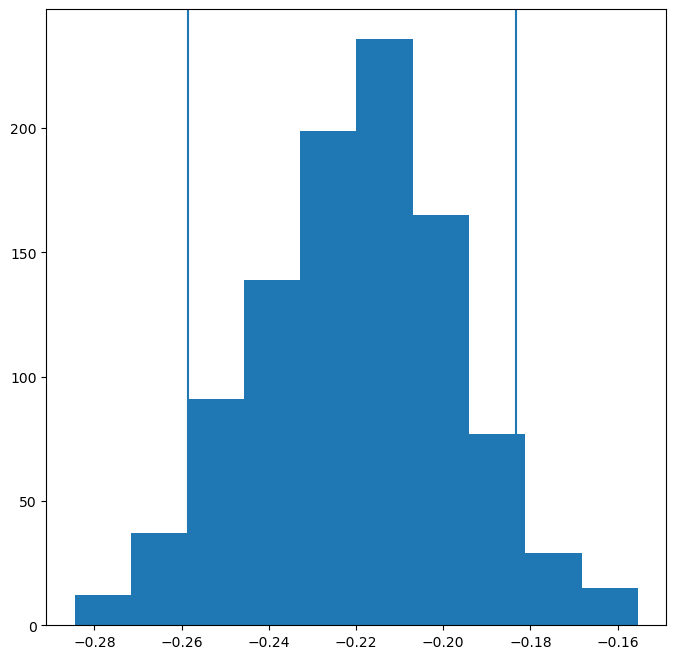

syn


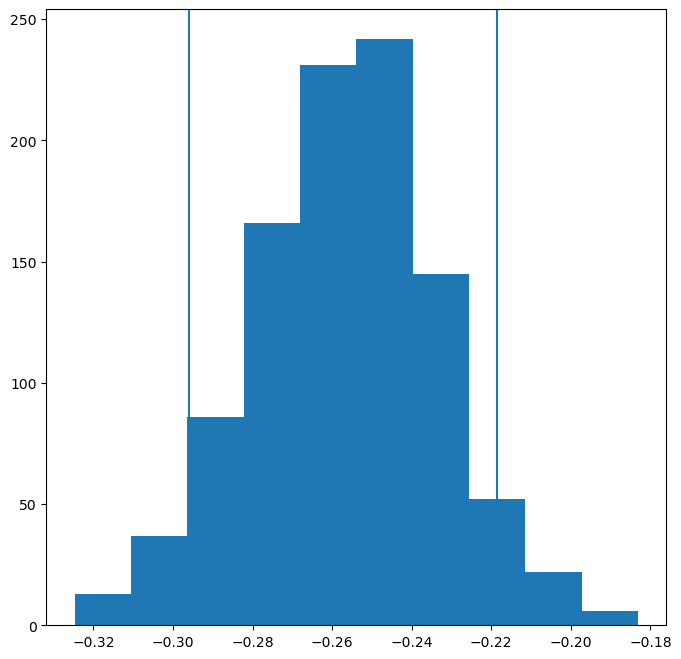

syn


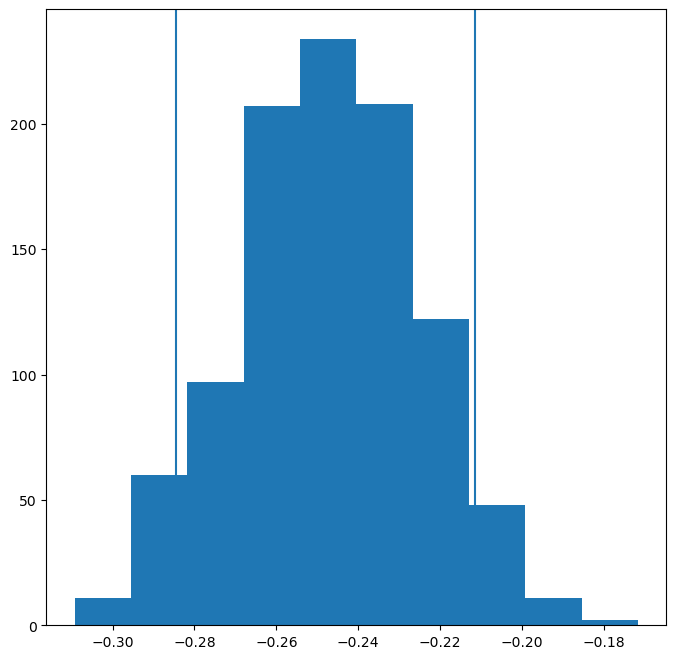

syn


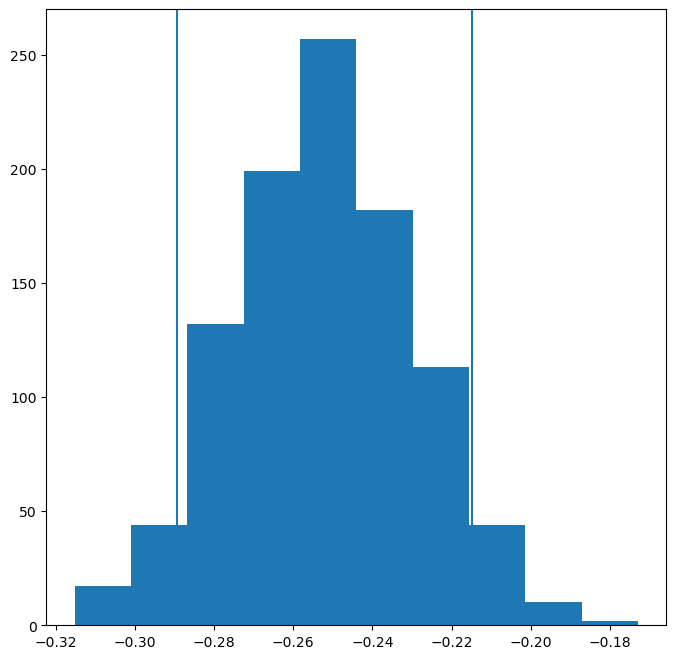

In [29]:
edges_red=[]
edges_syn=[]

for i in range(len(oinfo_numbers)):
#     plt.hist(oinfo_numbers[i])
#     plt.axvline(np.percentile(oinfo_numbers[i], 99))
#     plt.axvline(np.percentile(oinfo_numbers[i], 1))
#     plt.show()
#     plt.close()
    if np.sign(np.percentile(oinfo_numbers[i], 95))==np.sign(np.percentile(oinfo_numbers[i], 5)):
        
        if np.percentile(oinfo_numbers[i], 5)>0:
            edges_red.append(list_labels3[i])
            
            print('red')
            plt.hist(oinfo_numbers[i])
            plt.axvline(np.percentile(oinfo_numbers[i], 95))
            plt.axvline(np.percentile(oinfo_numbers[i], 5))
            plt.show()
            plt.close()
            #print('red')
        
        elif np.percentile(oinfo_numbers[i], 95)<0:
            edges_syn.append(list_labels3[i])
            print('syn')
            plt.hist(oinfo_numbers[i])
            plt.axvline(np.percentile(oinfo_numbers[i], 95))
            plt.axvline(np.percentile(oinfo_numbers[i], 5))
            plt.show()
            plt.close()
            #print('syn')
            


In [30]:
len(edges_red)

0

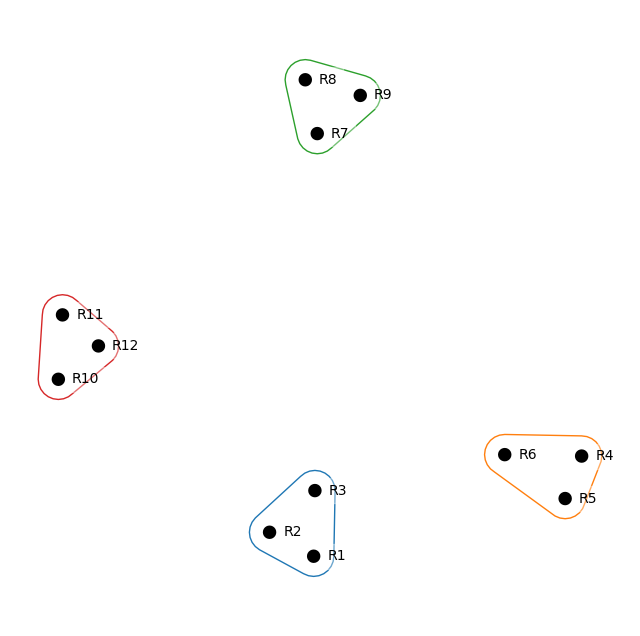

In [32]:
H=hnx.Hypergraph(edges_syn)

hnx.drawing.draw(H,
    with_color=False,
    with_edge_labels=False,
    with_node_labels=True)

## Let's go, order 4!!!

In [33]:
list_labels4=[]
oinfo_numbers4=[]
for mul in oinfo['roi'].data:
    if len(mul.split('-'))==4:
        list_labels4.append(mul.split('-'))
        oinfo_numbers4.append(oinfo.sel(roi=mul))

In [34]:
edges_red4=[]
edges_syn4=[]

for i in range(len(oinfo_numbers)):
    #plt.hist(oinfo_numbers[i])
    #plt.axvline(np.percentile(oinfo_numbers[i], 99))
    #plt.axvline(np.percentile(oinfo_numbers[i], 1))
    #plt.show()
    #plt.close()
    if np.percentile(oinfo_numbers[i], 95)*np.percentile(oinfo_numbers[i], 5) > 0:
        if np.percentile(oinfo_numbers[i], 5)>0:
            ok=0
            for sub_mul in list_labels3:
                if set(sub_mul)<set(list_labels4[i]):
                    sub_dat=oinfo.sel(roi=''.join([item+'-' for item in sub_mul])[:-1])
                    if np.percentile(sub_dat, 95)<np.percentile(oinfo_numbers[i], 5):
                        ok+=1
                        plt.hist(sub_dat, label='triplet '+''.join([item+'-' for item in sub_mul])[:-1])
            if ok==4:
                edges_red4.append(list_labels4[i])
                plt.hist(oinfo_numbers[i], label='four '+''.join([item+'-' for item in list_labels4[i]])[:-1])
                plt.legend()
                plt.show()
                plt.close()
            
        if np.percentile(oinfo_numbers[i], 95)<0:
            ok=0
            for sub_mul in list_labels3:
                if set(sub_mul)<set(list_labels4[i]):
                    sub_dat=oinfo.sel(roi=''.join([item+'-' for item in sub_mul])[:-1])
                    if np.percentile(sub_dat, 5)>np.percentile(oinfo_numbers[i], 95):
                        ok+=1
            if ok==4:
                edges_syn4.append(list_labels4[i])
            
        

In [16]:
''.join([item+'-' for item in list_labels[0]])[:-1]

NameError: name 'list_labels' is not defined

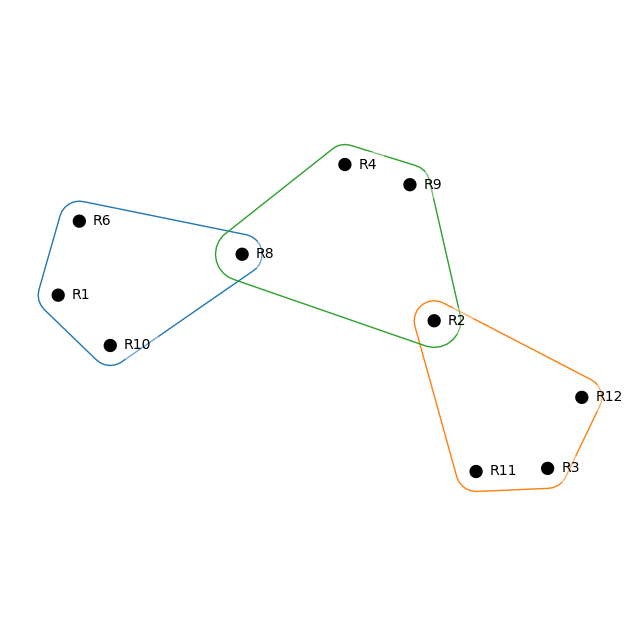

In [39]:
H=hnx.Hypergraph(edges_syn4)

hnx.drawing.draw(H,
    with_color=False,
    with_edge_labels=False,
    with_node_labels=True)

## Let's go, order 5!!!

In [41]:
list_labels5=[]
oinfo_numbers5=[]
for mul in oinfo['roi'].data:
    if len(mul.split('-'))==5:
        list_labels5.append(mul.split('-'))
        oinfo_numbers5.append(oinfo.sel(roi=mul))

edges_red5=[]
edges_syn5=[]

for i in range(len(oinfo_numbers)):
    #plt.hist(oinfo_numbers[i])
    #plt.axvline(np.percentile(oinfo_numbers[i], 99))
    #plt.axvline(np.percentile(oinfo_numbers[i], 1))
    #plt.show()
    #plt.close()
    if np.percentile(oinfo_numbers[i], 95)*np.percentile(oinfo_numbers[i], 5) > 0:
        if np.percentile(oinfo_numbers[i], 5)>0:
            ok=0
            for sub_mul3 in list_labels3:
                if set(sub_mul3)<set(list_labels5[i]):
                    sub_dat=oinfo.sel(roi=''.join([item+'-' for item in sub_mul3])[:-1])
                    if np.percentile(sub_dat, 95)<np.percentile(oinfo_numbers[i], 5):
                        ok+=1
            if ok==10:
                ok4=0
                for sub_mul4 in list_labels4:
                    if set(sub_mul4)<set(list_labels5[i]):
                        sub_dat=oinfo.sel(roi=''.join([item+'-' for item in sub_mul4])[:-1])
                        if np.percentile(sub_dat, 95)<np.percentile(oinfo_numbers[i], 5):
                            ok4+=1
                if ok4==5:
                    edges_red5.append(list_labels5[i])
                    
                    
        if np.percentile(oinfo_numbers[i], 95)<0:
            ok=0
            for sub_mul3 in list_labels3:
                if set(sub_mul3)<set(list_labels5[i]):
                    sub_dat=oinfo.sel(roi=''.join([item+'-' for item in sub_mul3])[:-1])
                    if np.percentile(sub_dat, 5)>np.percentile(oinfo_numbers[i], 95):
                        ok+=1
            if ok==10:
                ok4=0
                for sub_mul4 in list_labels4:
                    if set(sub_mul4)<set(list_labels5[i]):
                        sub_dat=oinfo.sel(roi=''.join([item+'-' for item in sub_mul4])[:-1])
                        if np.percentile(sub_dat, 5)>np.percentile(oinfo_numbers[i], 95):
                            ok4+=1
                if ok4==5:
                    edges_syn5.append(list_labels5[i])
    
            
        

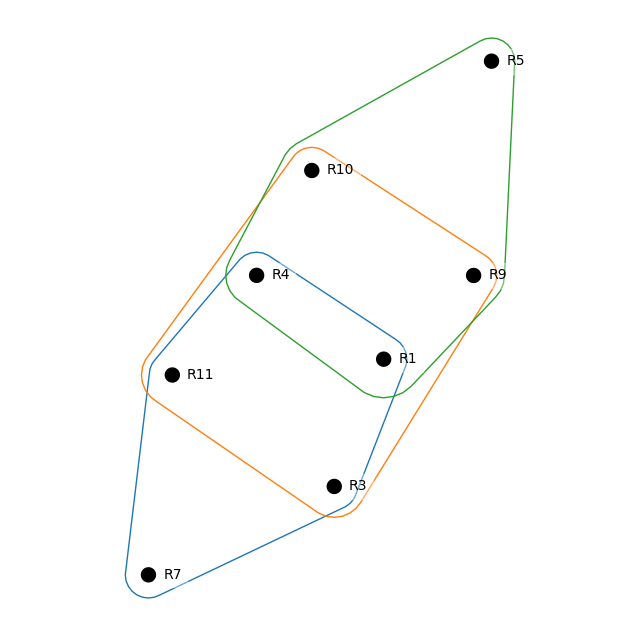

In [42]:
H=hnx.Hypergraph(edges_syn5)

hnx.drawing.draw(H,
    with_color=False,
    with_edge_labels=False,
    with_node_labels=True)

In [ ]:


    
if __name__ == '__main__':
    import matplotlib.pyplot as plt
    from frites import set_mpl_style
    import seaborn as sns
    n_sample=1000
    path="C:/Users/matte/Documents/HOI/Manip_Quest/Analyses/"
    
    
    
    #datas=genfromtxt(r'C:\Users\lisa\Documents\Cours_Formations_Conf_Labmeeting\BrainHack\BrainHAck_2022_Marseille\HOI\Datas2.csv', delimiter=',')
    #datas=np.genfromtxt(r'C:\Users\lisa\Documents\Cours_Formations_Conf_Labmeeting\BrainHack\BrainHAck_2022_Marseille\HOI\Datas2.csv',delimiter=',',names=True)
    datas=pd.read_csv(path+'Scale_fornetwork2.csv')
    cool_columns=list(datas.columns)
    cool_columns.remove('A4_taille')
    cool_columns.remove('A5_poids')
    cool_columns.remove('Unnamed: 0')
    datas=datas[cool_columns]
    print(datas.columns)
    datas_array=np.array(datas)

    
    for name_col in cool_columns:
        datas.columns = datas.columns.str.replace(name_col, name_col[:4])
    
    
    node_labels=[elem[:4] for elem in cool_columns]
    
    n_sub, n_quest = datas_array.shape

    arr=np.zeros((n_sub, n_quest, n_sample))
    
    arr[:,:,0]=datas.values
    
    print(arr.shape)
    for i in range(n_sample):
        
        arr[:,:,i]=arr[:,:,0][np.random.choice(np.arange(n_sub), n_sub),:]
        
        
    x = xr.DataArray(data=arr, dims=["Suj", "Quest","Time"],
                     coords=(datas.index, datas.columns, np.arange(n_sample)))
    
    

    oinfo = conn_hoi_oinfo(x, minsize=3, maxsize=4, y=None, roi="Quest",
                     times="Time")
    
    
    df = oinfo.to_pandas()
    
    


Index(['A3_age_m', 'A6_IMC', 'B_puberte', 'C_AP', 'D1_priv', 'D2_pub',
       'D3_anx_soc', 'E1_perspec', 'E2_empat', 'F2_reseauquant', 'G1_comp',
       'G2_cog', 'G3_affec', 'H1_appa', 'H2_attri', 'H3_poids', 'I_objectifi',
       'II1_fam', 'II2_pairs', 'II3_reseau', 'J_cons_corps', 'K1_notice',
       'K2_nodistract', 'K3_notworry', 'K4_emotion', 'K5_listing', 'K6_trust',
       'L1a_tact_dis_rech', 'L1b_tact_dis_seuil', 'L2_tact_soc',
       'L3_mouv_rech', 'L3_mouv_habil', 'L4_act_rech', 'L4_act_seuil',
       'M1_douleurs_nb', 'N_influence_pairs'],
      dtype='object')
(655, 36, 1000)


Defining links (n_roi=36; directed=False; net=False, nb_min_links=None)
    Sorting roi names


  0%|          |  : 0/66045 [00:00<?,       ?it/s]

Compute the  HOI (min=3; max=4)
    Copnorm the data
    Multiplets of size 3


# Order 3

In [17]:
list_labels=[]
oinfo_numbers=[]
for mul in oinfo['roi'].data:
    if len(mul.split('-'))==3:
        list_labels.append(mul.split('-'))
        oinfo_numbers.append(oinfo.sel(roi=mul))


In [18]:
oinfo_numbers=np.array(oinfo_numbers)

In [19]:
list_lab=[mul.split('-') for mul in list_labels]

AttributeError: 'list' object has no attribute 'split'

In [20]:
list_lab

NameError: name 'list_lab' is not defined

In [21]:
label_nodes=[elem[:4] for elem in cool_columns]

NameError: name 'cool_columns' is not defined

In [22]:
label_nodes

NameError: name 'label_nodes' is not defined

In [24]:
edges_red=[]
edges_syn=[]

for i in range(len(oinfo_numbers)):
    #plt.hist(oinfo_numbers[i])
    #plt.axvline(np.percentile(oinfo_numbers[i], 99))
    #plt.axvline(np.percentile(oinfo_numbers[i], 1))
    #plt.show()
    #plt.close()
    if np.percentile(oinfo_numbers[i], 95)*np.percentile(oinfo_numbers[i], 5) > 0:
        
        if np.percentile(oinfo_numbers[i], 5)>0.01:
            edges_red.append(list_labels[i])
            #print('red')
        elif np.percentile(oinfo_numbers[i], 95)<-0.01:
            edges_syn.append(list_labels[i])
            #print('syn')
            


In [25]:
len(edges_syn)

2

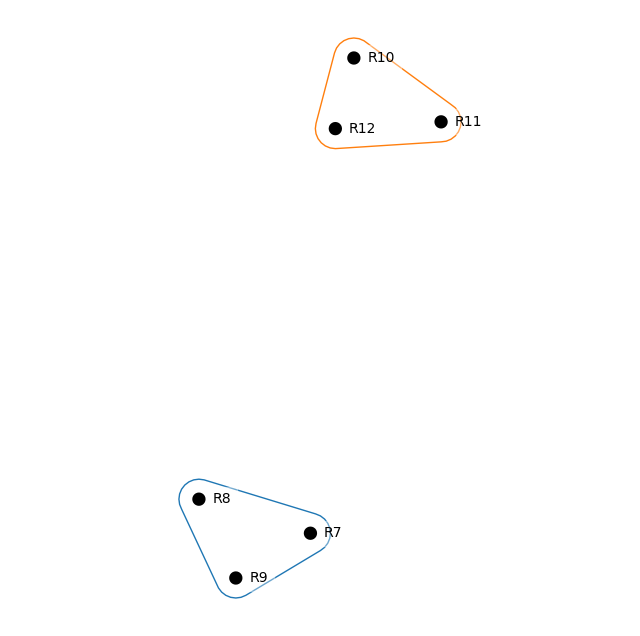

In [29]:
H=hnx.Hypergraph(edges_syn)

hnx.drawing.draw(H,
    with_color=False,
    with_edge_labels=False,
    with_node_labels=True)

In [193]:
strength_red=[]
strength_syn=[]

for elem in node_labels:
    countr=0
    counts=0
    for edgesr in edges_red:
        if elem in edgesr:
            countr+=1
    for edgess in edges_syn:
        if elem in edgess:
            counts+=1
    strength_red.append(countr)
    strength_syn.append(counts)
    
            
            

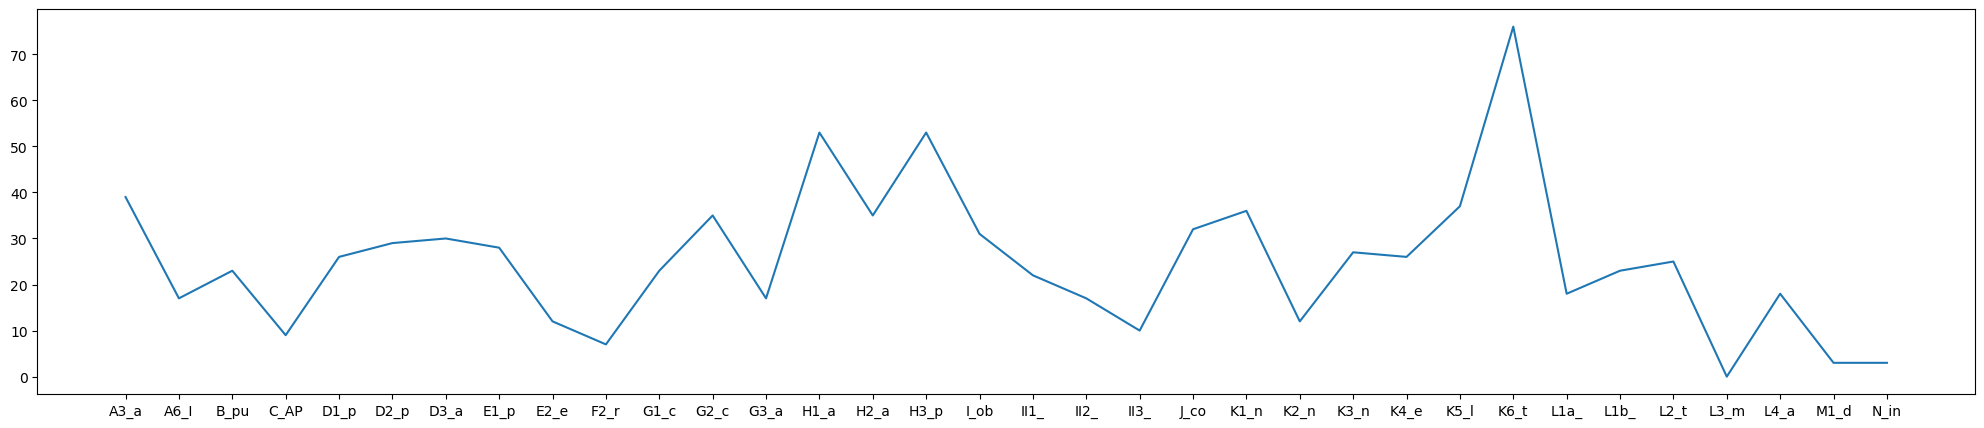

In [184]:
plt.figure(figsize=(25,5))
plt.plot(node_labels, strength_syn)
plt.show()
plt.close()



In [201]:
strength_red

[3,
 3,
 3,
 0,
 7,
 7,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 11,
 0,
 11,
 7,
 4,
 3,
 11,
 6,
 8,
 0,
 0,
 8,
 8,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

# Order 4

In the following cells we start the study of order 4

In [39]:
datas=pd.read_csv(path+'Scale_fornetwork2.csv')
    
datas.head()   
    
    

,Unnamed: 0,A3_age_m,A4_taille,A5_poids,A6_IMC,B_puberte,C_AP,D1_priv,D2_pub,D3_anx_soc,...,K6_trust,L1a_tact_dis_rech,L1b_tact_dis_seuil,L2_tact_soc,L3_mouv_rech,L3_mouv_habil,L4_act_rech,L4_act_seuil,M1_douleurs_nb,N_influence_pairs
0,0,146,146.0,38.0,17.826984,2.5,2.0,3.000000,1.714286,1.333333,...,5.000000,3.0,2.5,3.500000,3.8,4.333333,2.500000,4.50,NaN,2.777778
1,1,146,137.0,36.0,19.180564,2.0,2.0,2.500000,2.714286,1.666667,...,4.333333,3.4,3.0,3.285714,3.0,4.333333,2.800000,3.25,NaN,3.000000
2,2,261,157.0,60.0,24.341758,4.0,2.0,3.777778,2.857143,3.166667,...,4.000000,2.8,4.0,2.750000,4.0,4.000000,3.000000,3.25,NaN,2.777778
3,3,285,168.0,60.0,21.258503,4.0,3.0,4.000000,4.428571,4.166667,...,2.333333,3.4,2.5,4.375000,4.6,4.333333,3.833333,3.25,NaN,2.400000
4,4,278,173.0,70.0,23.388687,4.0,3.0,4.444444,4.142857,2.666667,...,4.000000,3.6,3.5,3.375000,3.8,4.000000,3.166667,3.00,1.0,2.500000


,Unnamed: 0,A3_age_m,A6_IMC,B_puberte,C_AP,D1_priv,D2_pub,D3_anx_soc,E1_perspec,E2_empat,...,K6_trust,L1a_tact_dis_rech,L1b_tact_dis_seuil,L2_tact_soc,L3_mouv_rech,L3_mouv_habil,L4_act_rech,L4_act_seuil,M1_douleurs_nb,N_influence_pairs
0,0,146,17.826984,2.50,2.0,3.000000,1.714286,1.333333,2.333333,2.142857,...,5.000000,3.00,2.5,3.500000,3.8,4.333333,2.500000,4.50,NaN,2.777778
1,1,146,19.180564,2.00,2.0,2.500000,2.714286,1.666667,3.500000,4.714286,...,4.333333,3.40,3.0,3.285714,3.0,4.333333,2.800000,3.25,NaN,3.000000
2,2,261,24.341758,4.00,2.0,3.777778,2.857143,3.166667,4.000000,4.000000,...,4.000000,2.80,4.0,2.750000,4.0,4.000000,3.000000,3.25,NaN,2.777778
3,3,285,21.258503,4.00,3.0,4.000000,4.428571,4.166667,2.833333,4.714286,...,2.333333,3.40,2.5,4.375000,4.6,4.333333,3.833333,3.25,NaN,2.400000
4,4,278,23.388687,4.00,3.0,4.444444,4.142857,2.666667,4.000000,4.571429,...,4.000000,3.60,3.5,3.375000,3.8,4.000000,3.166667,3.00,1.0,2.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650,650,252,24.023809,4.00,4.0,3.777778,3.285714,1.666667,3.333333,4.428571,...,5.000000,3.75,2.0,3.500000,3.2,4.333333,3.500000,4.50,NaN,2.700000
651,651,247,23.936062,4.00,2.0,4.222222,3.428571,3.833333,3.833333,4.285714,...,4.000000,3.80,1.5,2.375000,3.6,3.666667,2.333333,3.25,NaN,2.600000
652,652,175,18.166204,2.60,4.0,4.555556,4.857143,2.666667,4.500000,4.285714,...,3.666667,3.60,4.0,3.375000,4.6,2.666667,3.000000,4.50,NaN,2.400000
653,653,166,20.047446,3.20,1.0,4.250000,4.571429,4.666667,2.333333,4.000000,...,2.666667,3.20,5.0,2.000000,4.4,2.666667,2.500000,2.75,NaN,2.200000
